# Demo

The `mfanalysis` package allows us to perform fractal and multifractal analysis of signals

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
sns.set(style="darkgrid")

## Generating a signal

Let's first generate a brownian motion (fractional brownian motion with H=0.5)

In [5]:
from mfanalysis.generate_data import generate_fbm_path

In [6]:
X = generate_fbm_path(4096, 0.8)[:, 0]

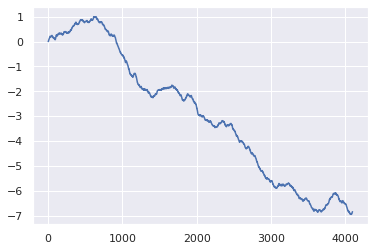

In [7]:
plt.plot(X)
plt.show()

## Second order analysis

Second order analysis is done with the `psd` module

The sampling frequency `fs` is necessary in order to correctly label the frequency axis

In [8]:
import mfanalysis.psd as psd

In [9]:
fs = 1

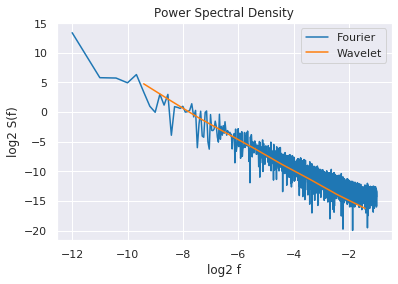

In [10]:
psd.plot_psd(X, fs, n_moments=2)

The Fourier-based PSD estimation is done using the Welch estimator.

The arguments relative the Fourier-based estimation are:
* `n_fft`: length of the FFT used
* `seg_size`: size of the segment used in the Welch estimation

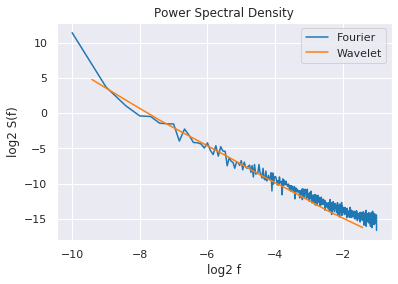

In [11]:
psd.plot_psd(X, fs, n_fft=1024)

The Wavelet-based estimation is done using wavelet analysis based on the Daubechies wavelet.

The number of vanishing moments can be controlled using the `n_moments` argument

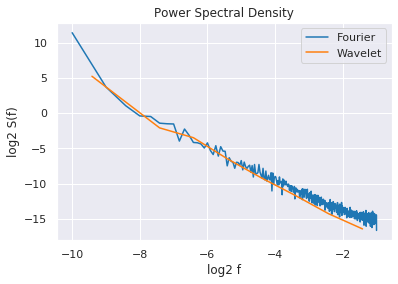

In [12]:
psd.plot_psd(X, fs, n_moments=3, n_fft=1024)

The wavelet-based estimation of the PSD is obtained via the `wavelet_estimation` function

In [13]:
PSD = psd.wavelet_estimation(X, fs, n_moments=3)

The output is an instance of the `PSD` namedtuple, with two fields: `freq` which contains the frequency support of the PSD estimation, and `psd` which contains the actual power estimates

In [14]:
PSD.freq, PSD.psd

(array([0.375     , 0.1875    , 0.09375   , 0.046875  , 0.0234375 ,
        0.01171875, 0.00585938, 0.00292969, 0.00146484]),
 array([1.12546932e-05, 4.99264111e-05, 3.10534197e-04, 1.73721881e-03,
        1.12741417e-02, 8.92457757e-02, 2.34884638e-01, 2.98124940e+00,
        3.77453893e+01]))

## Estimating beta

Our model for the power density spectrum is as follows:

$$ \Gamma(\nu) = C \left| \nu \right| ^ {\beta}$$

Using the log-log plot we can then easily estimate $beta$ by performing a linear regression over the wavelet PSD estimate

In [15]:
import mfanalysis.fractal_analysis as fa

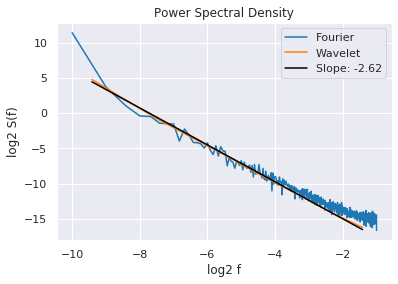

In [16]:
fa.plot_fractal(X, fs, freq_band=(0.001, 0.4), n_fft=1024)

The `freq_band` parameter controls the frequency support for the $\beta$ estimation

The `log` parameter allows us to control the log function used, which changes the axes values but not the plotted curves. Available values are contained in the `psd.log_function` dictionary

In [17]:
[*psd.log_function]

['log2', 'log']

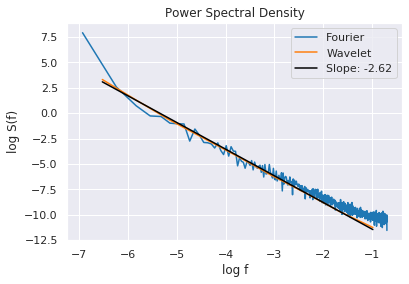

In [18]:
fa.plot_fractal(X, fs, freq_band=(0.001, 0.4), n_fft=1024, log='log')

The estimates of $\beta$ and $\log(C)$ can be directly obtained from the signal using the `fractal_analysis` function

In [19]:
fractal = fa.fractal_analysis(X, fs, n_moments=2, freq_band=(0.001, 0.4))

The output is an instance of the FractalValues namedtuple, which contains 3 fields:

- `beta`: the estimated 1/f slope
- `log_C`: the logged value of the 1/f intercept
- `freq`: the frequency support for the estimation

In [20]:
fractal

FractalValues(beta=-2.622576796975478, log_C=-20.24536514630078, freq=array([[-1.4150375],
       [-2.4150375],
       [-3.4150375],
       [-4.4150375],
       [-5.4150375],
       [-6.4150375],
       [-7.4150375],
       [-8.4150375],
       [-9.4150375]]))

## Wavelet Transform

Wavelet transform is performed in the package using the `wavelet` submodule

In [21]:
from mfanalysis.wavelet import wavelet_analysis

TODO: detail the wavelet transform

In [22]:
WT = wavelet_analysis(X)

/home/merlin/Multifracs/mfanalysis/mfanalysis/wavelet.py:100: UserWarning: Value of j2 is higher than the maximum allowed level. Max level and j2 set to 9
  f"Max level and j2 set to {max_level}", UserWarning)


The output is a namedtuple with 3 fields:

* `wt_leaders`: The wavelet leaders if computed
* `wt_coefs`: Wavelet coefficients
* `j2_eff`: Maximum scale that the coefficients were effectively computed for

## Multifractal Analysis

Multifractal analysis is done using the `mf_analysis` submodule

In [23]:
import mfanalysis.mf_analysis as mf

In [24]:
import numpy as np

Basic parameters are:

`j1` and `j2`, which indicate respectively the minimum and the maximum scale to consider when fitting wavelet coefficients

`q` The values of q for which the wavelet coefficients will be estimated

`n_cumul` The maximum order of the cumulants to compute

The p_exponent parameters `p_exp` controls how wavelet leaders are used: if set to an int, it will use wavelet p-leaders, or if set to `np.inf`, it will use the wavelet leaders.

The output of the `mf_analysis_full` function contains two variables, `dwt` and `lwt`. The former contains the multifractal variables computed using the wavelet coefs, while the latter uses the wavelet leaders.

By default the `p_exp` parameter is set to `None`, which means the wavelet coefs only are used, and so the `lwt` variable returned is set to `None`

In [52]:
dwt, lwt = mf.mf_analysis_full(X,
    j1=2, j2=8,
    q=np.arange(-2,3),
    n_cumul=2,
)

In [53]:
print(lwt)

None


**Unpacking dwt**

The variable dwt contains three fields: the structure functions, cumulants and multifractal spectrum. They can be unpacked all at once, or called one by one

In [54]:
sf, cumul, mfs = dwt

In [55]:
sf = dwt.structure
cumul = dwt.cumulants
mfs = dwt.spectrum

In [56]:
sf.j

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [57]:
sf.q

array([-2, -1,  0,  1,  2])

In [58]:
sf.mrq_name

'wavelet_coeffs'

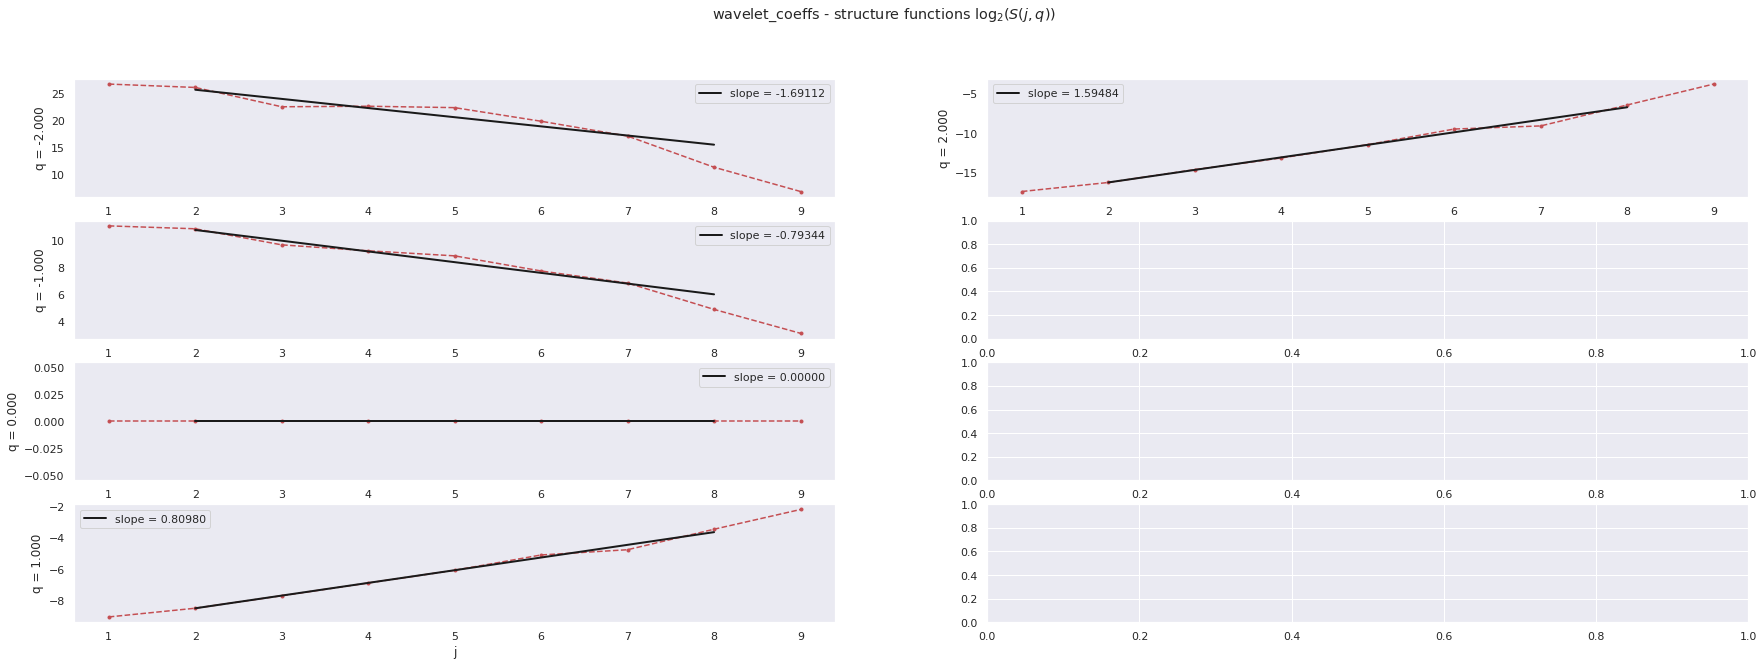

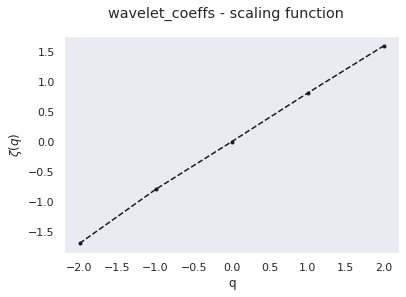

In [34]:
sf.plot()

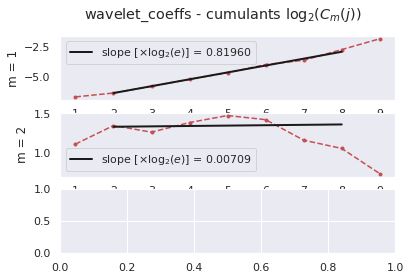

In [35]:
cumul.plot()

In [36]:
cumul.log_cumulants

array([0.81959909, 0.00708526])

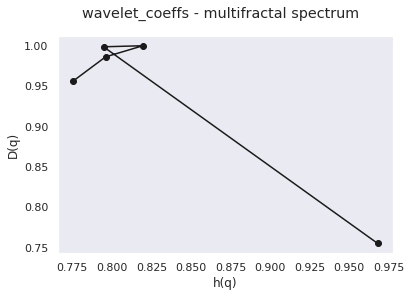

In [38]:
mfs.plot()

**Using p-leaders**

In [41]:
dwt, lwt = mf.mf_analysis_full(X,
    j1=2, j2=8,
    q=np.arange(-2,3),
    n_cumul=2,
    p_exp=2
)

The `lwt` variable shares the same structure as `dwt`

In [43]:
lwt_sf, lwt_cumul, lwt_mfs = lwt

The `lwt_sf`, `lwt_cumul`, `lwt_mfs` variables defined here share the same structure as the `sf`, `cumul`, and `mfs` variables defined previously

## Object oriented approach

The `Signal` dataclass offers an approach where the signal data and any intermediary results and parameters are kept in an instance

In [59]:
import mfanalysis.signal as sig

In [60]:
S = sig.Signal(X, fs, 'log')

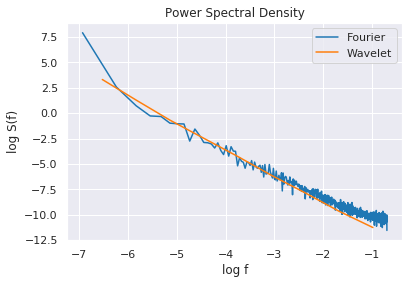

In [61]:
S.plot_psd(n_fft=1024)

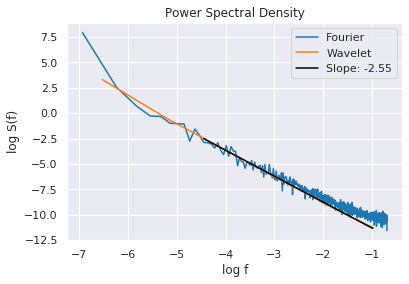

In [62]:
S.plot_fractal(n_fft=1024)

In [63]:
S.fractal_analysis()

FractalValues(beta=-2.5496376933101113, log_C=-13.854354677177184, freq=array([[-0.98082925],
       [-1.67397643],
       [-2.36712361],
       [-3.06027079],
       [-3.75341798],
       [-4.44656516]]))

In [64]:
S.wt_psd

PSD(freq=array([0.375     , 0.1875    , 0.09375   , 0.046875  , 0.0234375 ,
       0.01171875, 0.00585938, 0.00292969, 0.00146484]), psd=array([1.29075263e-05, 6.39677720e-05, 3.89915716e-04, 2.20122653e-03,
       1.41902167e-02, 8.42382823e-02, 5.01985149e-01, 3.61909171e+00,
       2.74098852e+01]))

In [65]:
S.welch_psd

PSD(freq=array([0.        , 0.00097656, 0.00195312, 0.00292969, 0.00390625,
       0.00488281, 0.00585938, 0.00683594, 0.0078125 , 0.00878906,
       0.00976562, 0.01074219, 0.01171875, 0.01269531, 0.01367188,
       0.01464844, 0.015625  , 0.01660156, 0.01757812, 0.01855469,
       0.01953125, 0.02050781, 0.02148438, 0.02246094, 0.0234375 ,
       0.02441406, 0.02539062, 0.02636719, 0.02734375, 0.02832031,
       0.02929688, 0.03027344, 0.03125   , 0.03222656, 0.03320312,
       0.03417969, 0.03515625, 0.03613281, 0.03710938, 0.03808594,
       0.0390625 , 0.04003906, 0.04101562, 0.04199219, 0.04296875,
       0.04394531, 0.04492188, 0.04589844, 0.046875  , 0.04785156,
       0.04882812, 0.04980469, 0.05078125, 0.05175781, 0.05273438,
       0.05371094, 0.0546875 , 0.05566406, 0.05664062, 0.05761719,
       0.05859375, 0.05957031, 0.06054688, 0.06152344, 0.0625    ,
       0.06347656, 0.06445312, 0.06542969, 0.06640625, 0.06738281,
       0.06835938, 0.06933594, 0.0703125 , 0.07128906

In [66]:
S.fractal

FractalValues(beta=-2.5496376933101113, log_C=-13.854354677177184, freq=array([[-0.98082925],
       [-1.67397643],
       [-2.36712361],
       [-3.06027079],
       [-3.75341798],
       [-4.44656516]]))